In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader as pdr #read data from online data sources like FRED or Yahoo
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Scrape the data from the website
url = 'https://www.transtats.bts.gov/Data_Elements.aspx?Data=1'
df = pd.read_html(url)
df = df[9]

In [3]:
# Clean and prepare domestic air passenger data
# Remove rows that represent annual totals
df = df.loc[df['Month']!='TOTAL']
# Create a column of time
df['Time'] = list(range(1,len(df)+1))
df['COVID'] = 0
df['COVID'][209:222] = 1
df = df.reset_index()

/var/folders/1m/drszvmqd3md6h7f9845dy7mr0000gn/T/ipykernel_50523/3681482297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
df

,index,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL,Time,COVID
0,0,2002,10,48054917,9578435,57633352,1,0
1,1,2002,11,44850246,9016535,53866781,2,0
2,2,2002,12,49684353,10038794,59723147,3,0
3,4,2003,1,43032450,9726436,52758886,4,0
4,5,2003,2,41166780,8283372,49450152,5,0
...,...,...,...,...,...,...,...,...
233,253,2022,3,64604568,13262417,77866985,234,0
234,254,2022,4,63514551,14711677,78226228,235,0
235,255,2022,5,66957127,15929406,82886533,236,0
236,256,2022,6,67365493,18185740,85551233,237,0


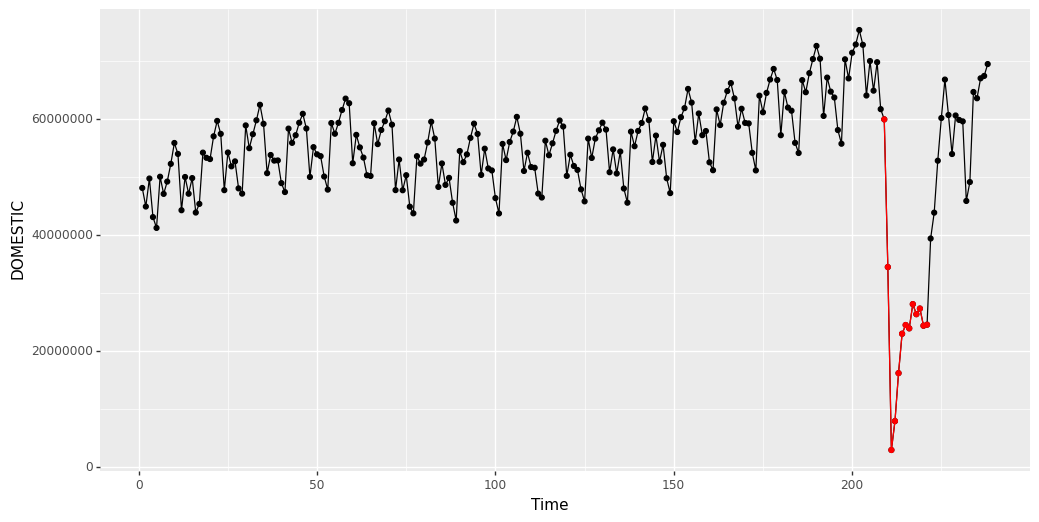

<ggplot: (8776520256247)>

In [5]:
# Data Visualization 1: Plot Domestic air passenger data. Use a different colors to color data during the covid period
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line() +
 geom_point(df.loc[(df.Time <= 221) & (df.Time >= 209),], aes('Time','DOMESTIC'), color='red') +
 geom_line(df.loc[(df.Time <= 221) & (df.Time >= 209),], aes('Time','DOMESTIC'), color='red') +
 theme(figure_size=(12,6)) 
)

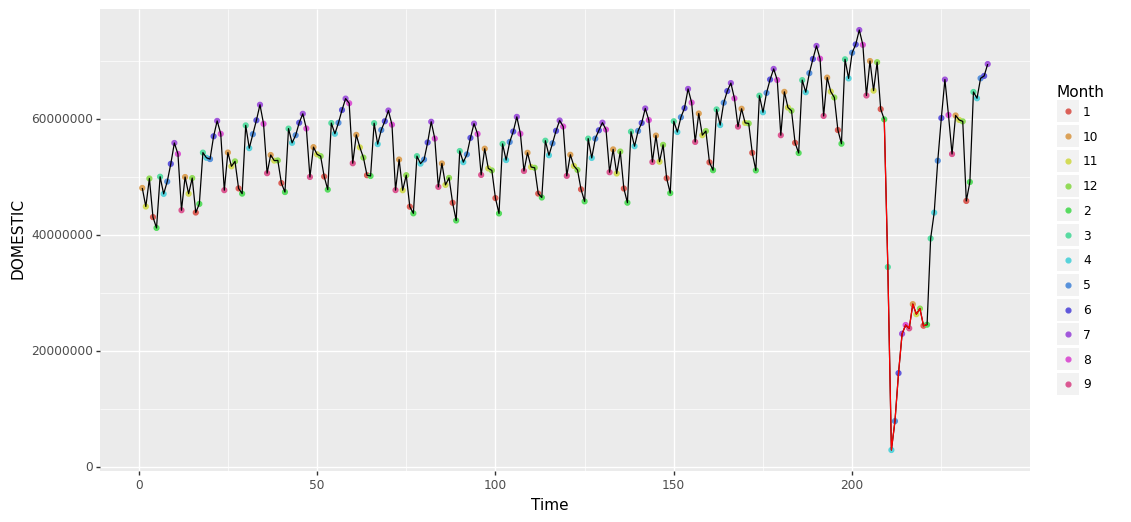

<ggplot: (8776497452517)>

In [6]:
# Data Visualization 2: Recreate the previous graph and color each month differently.
(
  ggplot(df,aes('Time','DOMESTIC')) + geom_point(aes('Time','DOMESTIC',color = 'Month',group=1)) +
  geom_line() +
  geom_line(df.loc[(df.Time <= 221) & (df.Time >= 209),], aes('Time','DOMESTIC'), color='red') +
  theme(figure_size=(12,6))
)

In [7]:
df['DomesticBefore'] = df['DOMESTIC']
df.loc[(len(df)-29):,'DomesticBefore'] = np.nan

In [8]:
df['Trend'] = list(range(1,len(df)+1))
M1 = smf.ols('DomesticBefore ~ Trend + C(Month)', data = df).fit()
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:         DomesticBefore   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     60.11
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.49e-59
Time:                        15:51:20   Log-Likelihood:                -3421.1
No. Observations:                 209   AIC:                             6868.
Df Residuals:                     196   BIC:                             6912.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        4.26e+07   8.52e+05     50.

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


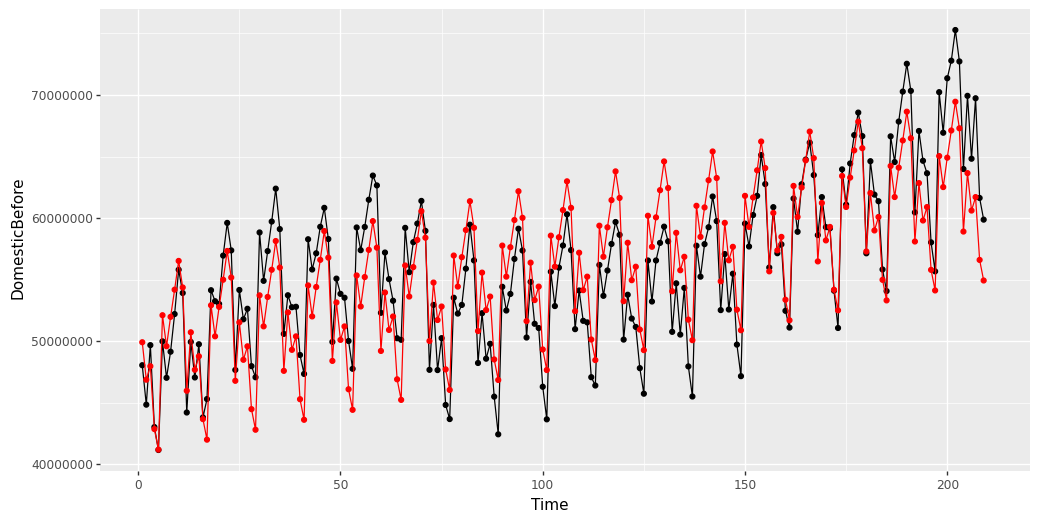

<ggplot: (8776496879610)>

In [9]:
# M1 = trend + seasonal
df['M1'] = M1.fittedvalues
(
    ggplot(df.loc[:(len(df)-29)],aes('Time','DomesticBefore')) + geom_point() + geom_line() +
 geom_point(aes('Time','M1'), color='red') + geom_line(aes('Time','M1'),color='red') + theme(figure_size = (12,6))
)

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


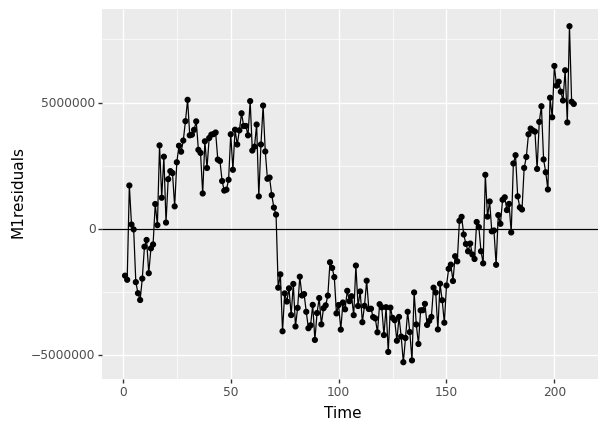

<ggplot: (8776500280814)>

In [10]:
df['M1residuals'] = M1.resid
(
    ggplot(df.loc[:(len(df)-29)],aes('Time','M1residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


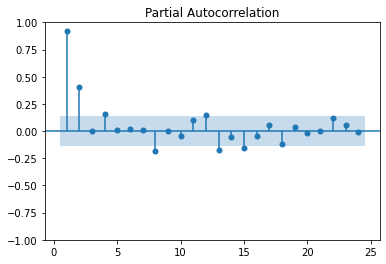

In [11]:
# residual is cyclical --> plot acf
plot_pacf(df.loc[df['M1residuals'].notna(),'M1residuals'], zero = False);

In [12]:
# lag 1 and 2 are significant
df['DomesticBeforeLag1'] = df['DomesticBefore'].shift(1)
df['DomesticBeforeLag2'] = df['DomesticBefore'].shift(2)

In [13]:
# M2 = trend + seasonal + cyclical component
M2 = smf.ols('DomesticBefore ~ Trend + C(Month) + DomesticBeforeLag1 + DomesticBeforeLag2',data = df).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:         DomesticBefore   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     504.0
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          4.77e-143
Time:                        15:51:21   Log-Likelihood:                -3171.2
No. Observations:                 207   AIC:                             6372.
Df Residuals:                     192   BIC:                             6422.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.957e+06   1.26

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


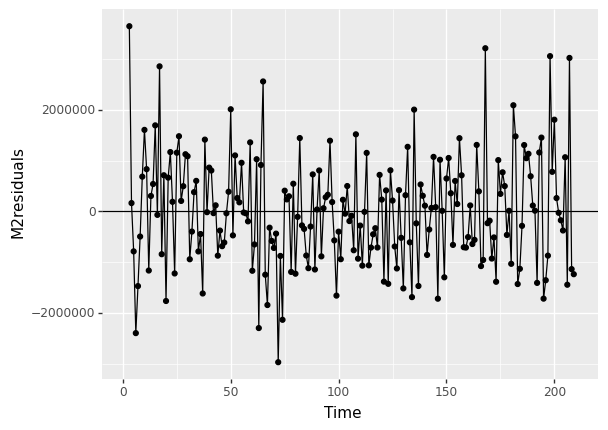

<ggplot: (8776496911641)>

In [14]:
df['M2'] = M2.fittedvalues
df['M2residuals'] = M2.resid
(
    ggplot(df.loc[:(len(df)-29)],aes('Time','M2residuals')) + geom_point() + geom_line() +
    geom_hline(yintercept = 0)
)
# it is now due to noise

In [15]:
# prediction after covid
df['M1'] = M1.predict(df)

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


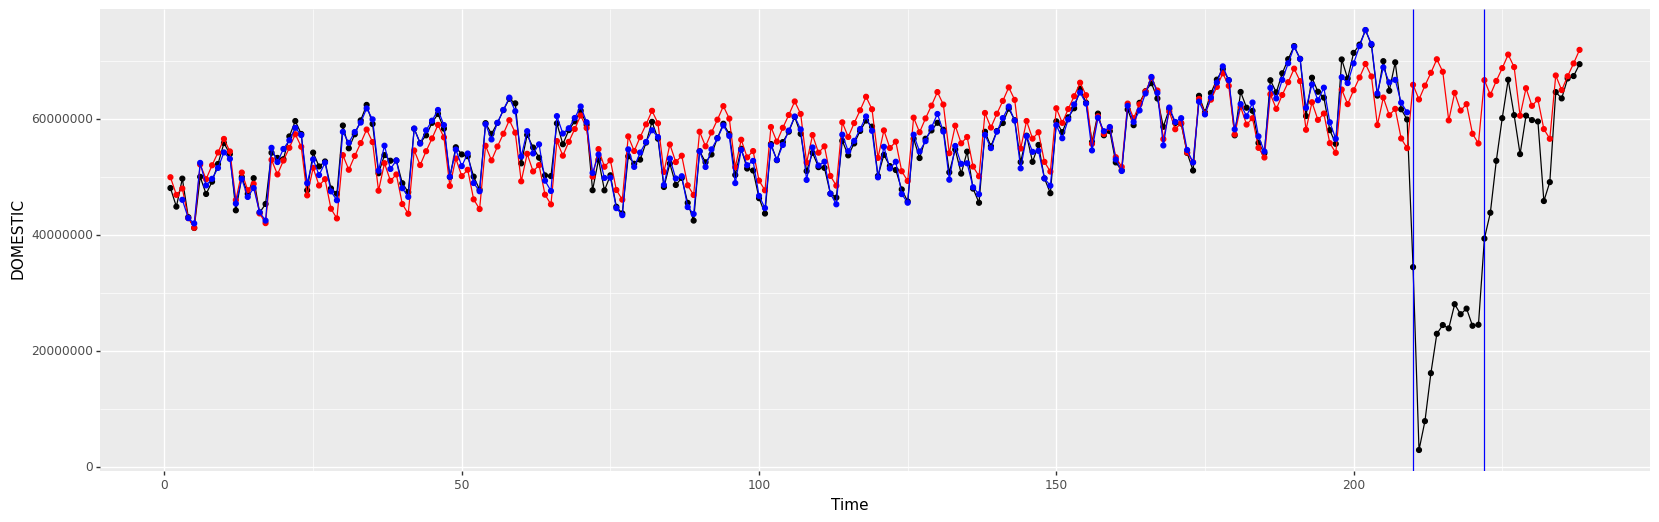

<ggplot: (8776501578132)>

In [16]:
# Plot data and overlay fitted values
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line() +
 geom_point(aes('Time','M1'), color='red') + geom_line(aes('Time','M1'),color='red') + theme(figure_size = (20,6))+
 geom_vline(xintercept = len(df)- 28, color ='blue', size = 0.5) + geom_vline(xintercept = len(df)- 16, color='blue',size=0.5) +
 geom_point(aes('Time','M2'), color='blue') + geom_line(aes('Time','M2'),color='blue')
)

In [17]:
# ---Prediction using smoothing Model-----
M = ExponentialSmoothing(df.loc[:(len(df) -29-1),'DOMESTIC'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [18]:
df.loc[:(len(df) -29-1),'M'] = M.fittedvalues

In [19]:
df.loc[(len(df) -29):,'M'] = M.forecast(29)
df['Prediction'] = 'Fitted Values'
df.loc[(len(df) -29):,'Prediction'] = 'Forcast'

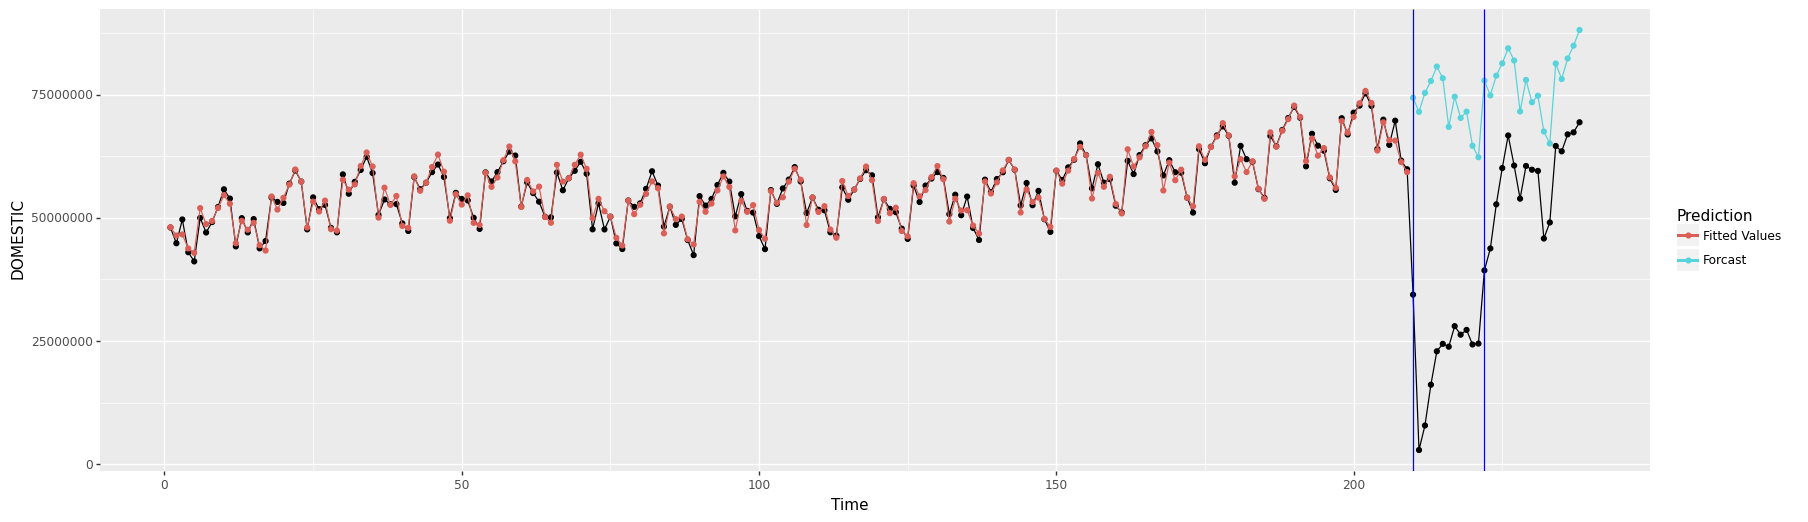

<ggplot: (8776503101690)>

In [20]:
# Crate a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line()+
 geom_point(aes('Time','M',color='Prediction')) + geom_line(aes('Time','M',color='Prediction')) +
 geom_vline(xintercept = len(df)- 28, color ='blue', size = 0.5) + geom_vline(xintercept = len(df)- 16, color='blue',size=0.5) + theme(figure_size = (20,6))
)

In [21]:
# impact of COVID = actual DOMESTIC - prediction assuming covid has not happened
round(df.loc[((df.Time <= 221) & (df.Time >= 209)),'DOMESTIC'].sum() - df.loc[((df.Time <= 221) & (df.Time >= 209)),'M'].sum()*1000,0)

-929058678933.0

In [22]:
# % impact = 
# (total  predicted demand during covid assuming covid has not happened - total actual demand during covid) / total  predicted demand during covid assuming covid has not happened
(df.loc[((df.Time <= 221) & (df.Time >= 209)),'M'].sum() - df.loc[((df.Time <= 221) & (df.Time >= 209)),'DOMESTIC'].sum()) / df.loc[((df.Time <= 221) & (df.Time >= 209)),'M2'].sum()

9.925532995209734

In [23]:
def rmse(actual,predicted):
    return round(((actual - predicted)**2).mean()**0.5,2)

In [24]:
def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)

In [25]:
def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train:],predicted[n_train:])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:],predicted[n_train:])
    return accuracy_metrics

In [26]:
# Smoothing model: senario 1_
# Training set: start = 10/2002, end=12/2019
# Testing set:  start = 01/2020, end=12/2020

In [48]:
M7 = ExponentialSmoothing(df.loc[:207,'DOMESTIC'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
df.loc[:206,'M7'] = M7.fittedvalues
df.loc[207:218,'M7'] = M7.forecast(12)

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [50]:
accuracy(actual = df.loc[:218,'DOMESTIC'], predicted = df.loc[:218,'M7'],h=12)

,RMSE,MAPE(%)
Training set,1148475.62,1.6
Testing set,51002276.36,442.89


In [29]:
# Smoothing model: senario 2
# Training set: start = 10/2002, end=12/2018
# Testing set:  start = 01/2019, end=12/2019

In [30]:
M8 = ExponentialSmoothing(df.loc[:194,'DOMESTIC'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
df.loc[:194,'M8'] = M8.fittedvalues
df.loc[195:206,'M8'] = M8.forecast(12)

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [31]:
accuracy(actual = df.loc[:206,'DOMESTIC'], predicted = df.loc[:206,'M8'],h=12)

,RMSE,MAPE(%)
Training set,1137758.78,1.63
Testing set,1219661.98,0.96


In [32]:
# Smoothing model: senario 3
# Training set: start = 10/2002, end=12/2017
# Testing set:  start = 01/2018, end=12/2018

In [33]:
M9 = ExponentialSmoothing(df.loc[:182,'DOMESTIC'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
df.loc[:182,'M9'] = M9.fittedvalues
df.loc[183:194,'M9'] = M9.forecast(12)

/Users/alissa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


In [34]:
accuracy(actual = df.loc[:194,'DOMESTIC'], predicted = df.loc[:194,'M9'],h=12)

,RMSE,MAPE(%)
Training set,1155952.66,1.69
Testing set,740358.34,0.77


In [38]:
dfFuture = pd.DataFrame({'Time':list(range(238,238+12)),
                         'FutureForecast':M.forecast(12)})

In [39]:
RMSE = (M.sse / len(df))**0.5
df['LowerBound'] = df['M'] - 2*RMSE
df['UpperBound'] = df['M'] + 2*RMSE

dfFuture['LowerBound'] = (dfFuture['FutureForecast'] - 2*RMSE).astype(float)
dfFuture['UpperBound'] = (dfFuture['FutureForecast'] + 2*RMSE).astype(float)

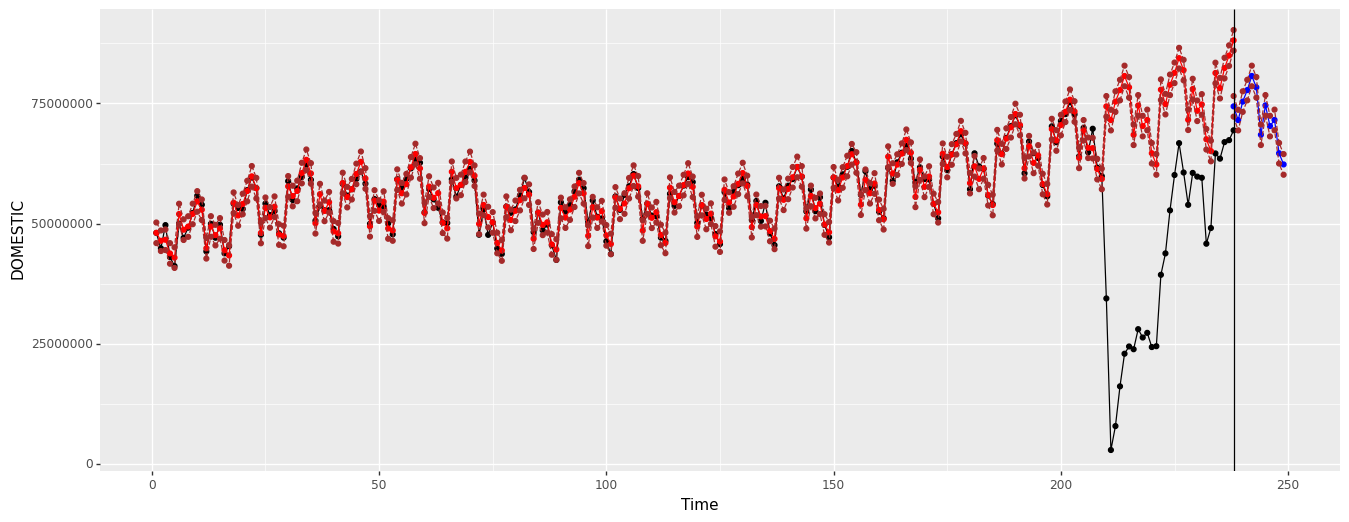

<ggplot: (8776497149067)>

In [40]:
# Create a a graph of data and overlay fitted values, and future forecats. 
CI = 'brown'
style='dashed'
(
    ggplot(df,aes('Time','DOMESTIC')) + geom_point() + geom_line()+   # data
  geom_point(aes('Time','M'),color='red') + geom_line(aes('Time','M'),color='red') +        # fitted/predicted values
 geom_point(dfFuture,aes('Time','FutureForecast'),color='blue') + geom_line(dfFuture, aes('Time','FutureForecast'),color='blue') +
 geom_point(aes('Time','LowerBound'),color=CI) + geom_line(aes('Time','LowerBound'),color=CI, linetype=style) +
 geom_point(aes('Time','UpperBound'),color=CI) + geom_line(aes('Time','UpperBound'),color=CI, linetype=style) +
 geom_point(dfFuture,aes('Time','LowerBound'),color=CI) + geom_line(dfFuture,aes('Time','LowerBound'),color=CI, linetype=style) +
 geom_point(dfFuture,aes('Time','UpperBound'),color=CI) + geom_line(dfFuture,aes('Time','UpperBound'),color=CI, linetype=style)+ 
 geom_vline(xintercept = len(df)) +  theme(figure_size=(16,6))
)